# Data Loading, Data Preparation 

## Importing libraries and Loading dataset 

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv('amazon_delivery.csv')

- First view of the dataset.

In [3]:
df.head()

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys


### Dataset description 

|Variable Name|Description|
|-|-|
|Order_ID| Unique identifier for each order.|
|Agent_Age| Age of the delivery agent.|
|Agent_Rating| Rating of the delivery agent.|
|Store_Latitude/Longitude| Geographic location of the store.|
|Drop_Latitude/Longitude| Geographic location of the delivery address.|
|Order_Date/Order_Time| Date and time when the order was placed.|
|Pickup_Time| Time when the delivery agent picked up the order.|
|Weather| Weather conditions during delivery.|
|Traffic |Traffic conditions during delivery.|
|Vehicle |Mode of transportation used for delivery.|
|Area |Type of delivery area (Urban/Metropolitan).|
|Delivery_Time |Target variable representing the actual time taken for delivery (in hours).|
|Category |Category of the product being delivered.|


## Statistical Analysis

- Dataset Info 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         43739 non-null  object 
 1   Agent_Age        43739 non-null  int64  
 2   Agent_Rating     43685 non-null  float64
 3   Store_Latitude   43739 non-null  float64
 4   Store_Longitude  43739 non-null  float64
 5   Drop_Latitude    43739 non-null  float64
 6   Drop_Longitude   43739 non-null  float64
 7   Order_Date       43739 non-null  object 
 8   Order_Time       43739 non-null  object 
 9   Pickup_Time      43739 non-null  object 
 10  Weather          43648 non-null  object 
 11  Traffic          43739 non-null  object 
 12  Vehicle          43739 non-null  object 
 13  Area             43739 non-null  object 
 14  Delivery_Time    43739 non-null  int64  
 15  Category         43739 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 5.3+ MB


- Converting Order_Date into datetime 

In [5]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

- Converting pickup_time and order_time to datetime 

In [6]:
df['Order_Time'] = pd.to_datetime(df['Order_Time'], format = '%H:%M:%S', errors='coerce').dt.time

In [7]:
df['Pickup_Time'] = pd.to_datetime(df['Pickup_Time'],format= '%H:%M:%S' , errors='coerce').dt.time

In [8]:
# Merging Order_date and Order_time 

df['Order_DateTime'] = pd.to_datetime(
    df['Order_Date'].astype(str) + ' ' + df['Order_Time'].astype(str),
    errors='coerce'
)

## Feature Engineering 

- We will be using Haversine formula to calculate the distance between store and drop locations.
- Haversine formula uses longitude and latitude for calculating distances.
- The formula is Haversine :
  - distance = R * c
  - c = 2 * arcsin(a^1/2)
  - a = sin^2(d/2) + cos(d1) * cos(d2) * sin^2(dl/2)
- where,
    - d1,d2 = latitudes in radians
    - d = d2 -d1
    - dl = (dl2 - dl1)difference in longitudes
    - R = 6371 km (earth's radius)

In [9]:
# We have latitude and longitudes in degrees we have to convert them into radians.

In [10]:
df['Store_Longitude_rad'] = np.radians(df['Store_Longitude'])
df['Store_Latitude_rad'] = np.radians(df['Store_Latitude'])

In [11]:
df['Drop_Longitude_rad'] = np.radians(df['Drop_Longitude'])
df['Drop_Latitude_rad'] = np.radians(df['Drop_Latitude'])

In [12]:
# Now defining the formula 

In [13]:
def haversine_formula(d1,dl1,d2,dl2):
    R = 6371
    d = d2-d1
    dl = dl2-dl1

    a = np.sin(d/2)**2 + np.cos(d1) * np.cos(d2) * np.sin(dl/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [14]:
df['Distance_KM'] = haversine_formula(
    df['Store_Latitude_rad'],
    df['Store_Longitude_rad'],
    df['Drop_Latitude_rad'],
    df['Drop_Longitude_rad']
)

- Handling Outliers 

In [15]:
df['Distance_KM'].describe()

count    43739.000000
mean        38.561752
std        534.564299
min          1.465067
25%          4.663432
50%          9.220450
75%         13.682379
max      19692.674606
Name: Distance_KM, dtype: float64

In [16]:
# We can see that, the 75% of the data or distance is smaller than 14kms, and remaining 25% is basically outliers.
# Lets fix outliers using IQR

In [17]:
# IQR
Q1 = df['Distance_KM'].quantile(0.25)
Q3 = df['Distance_KM'].quantile(0.75)

iqr = Q3 - Q1

upper_bound = Q3 + (1.5*iqr)
lower_bound = Q1 - (1.5*iqr)

In [18]:
df['Distance_KM'] = df['Distance_KM'].clip(lower=lower_bound,upper=upper_bound)

In [19]:
# Pickup_delay(mins) = Pickup_time - Order_time
# assuming the same date for pickup as order date 

In [20]:
# Merging Order_date and Pickup_time 

df['Pickup_DateTime'] = pd.to_datetime(
    df['Order_Date'].astype(str) + ' ' + df['Pickup_Time'].astype(str),
    errors='coerce'
)

In [21]:
df['Pickup_delay'] = (df['Pickup_DateTime'] - df['Order_DateTime']).dt.total_seconds()/60

In [22]:
df['Pickup_delay'] = df['Pickup_delay'].clip(lower=0)

In [23]:
# Now we can drop 'Store_Latitude','Store_Longitude','Drop_Latitude','Drop_Longitude' as we have values in radians.

In [24]:
df.drop(['Store_Latitude','Store_Longitude','Drop_Latitude','Drop_Longitude'],axis=1,inplace=True)

In [25]:
(df['Agent_Rating'] == 6).sum()

53

In [26]:
# We can see there are 53 rows with rating of 6, generally ratings are out of 5, so we will keep the ratings in range of 0-5.
df = df[(df['Agent_Rating'] <= 5) & (df['Agent_Rating'] >= 0)]

## Scaling and Encoding 

In [27]:
# Applying StandardScaler for 'Distance_KM','Pickup_delay','Agent_Rating'

In [28]:
from sklearn.preprocessing import StandardScaler

In [29]:
ss = StandardScaler()

In [30]:
df[['Distance_KM_ss','Pickup_delay_ss','Agent_Rating_ss']] = ss.fit_transform(df[['Distance_KM','Pickup_delay','Agent_Rating']])

In [31]:
# Applying one hot encoding to 'Traffic', weather, area, vehicle

In [32]:
df = pd.get_dummies(data=df,columns=['Weather','Traffic','Area','Vehicle'],dtype=int)

# EDA

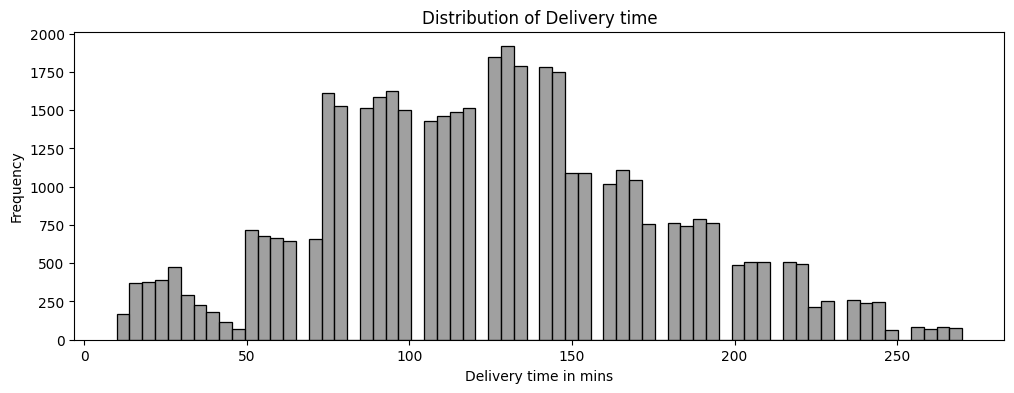

In [33]:
# Distribution of Delivery time

plt.figure(figsize=[12,4])
sns.histplot(df,x=df['Delivery_Time'],color='grey')
plt.title('Distribution of Delivery time')
plt.xlabel('Delivery time in mins')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

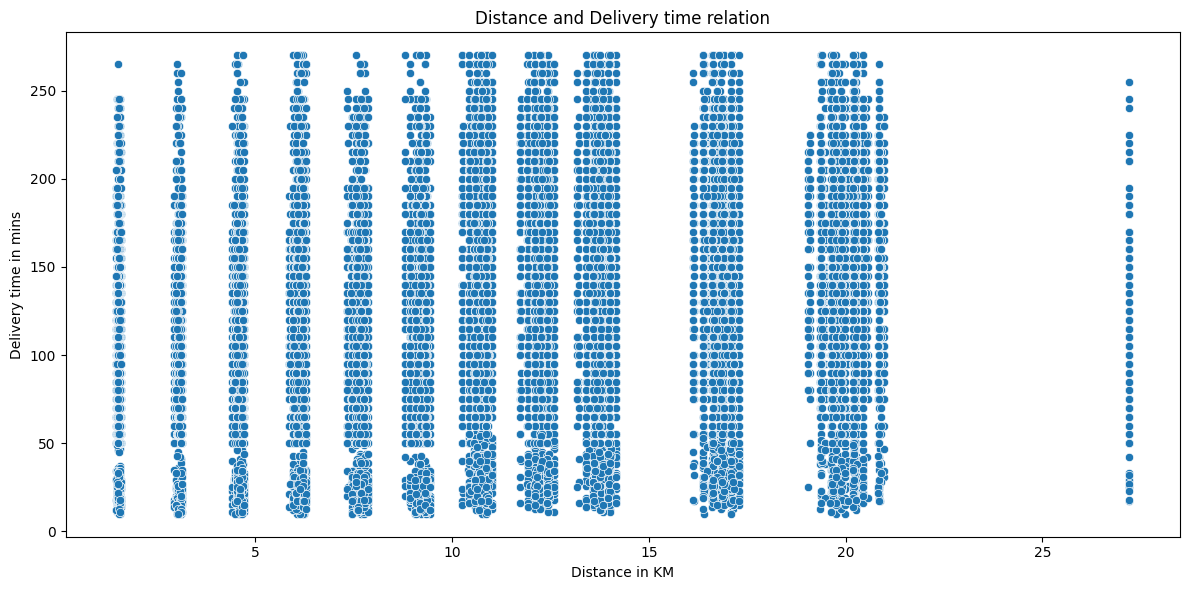

In [35]:
# Relationship between Distance and Delivery time 

plt.figure(figsize=[12,6])
sns.scatterplot(data=df,x=df['Distance_KM'],y=df['Delivery_Time'])
plt.title('Distance and Delivery time relation')
plt.xlabel('Distance in KM')
plt.ylabel('Delivery time in mins')
plt.tight_layout()
plt.show()

In [36]:
df.columns

Index(['Order_ID', 'Agent_Age', 'Agent_Rating', 'Order_Date', 'Order_Time',
       'Pickup_Time', 'Delivery_Time', 'Category', 'Order_DateTime',
       'Store_Longitude_rad', 'Store_Latitude_rad', 'Drop_Longitude_rad',
       'Drop_Latitude_rad', 'Distance_KM', 'Pickup_DateTime', 'Pickup_delay',
       'Distance_KM_ss', 'Pickup_delay_ss', 'Agent_Rating_ss',
       'Weather_Cloudy', 'Weather_Fog', 'Weather_Sandstorms', 'Weather_Stormy',
       'Weather_Sunny', 'Weather_Windy', 'Traffic_High ', 'Traffic_Jam ',
       'Traffic_Low ', 'Traffic_Medium ', 'Traffic_NaN ',
       'Area_Metropolitian ', 'Area_Other', 'Area_Semi-Urban ', 'Area_Urban ',
       'Vehicle_bicycle ', 'Vehicle_motorcycle ', 'Vehicle_scooter ',
       'Vehicle_van'],
      dtype='object')

In [ ]:
# Agent Performance Across various conditions

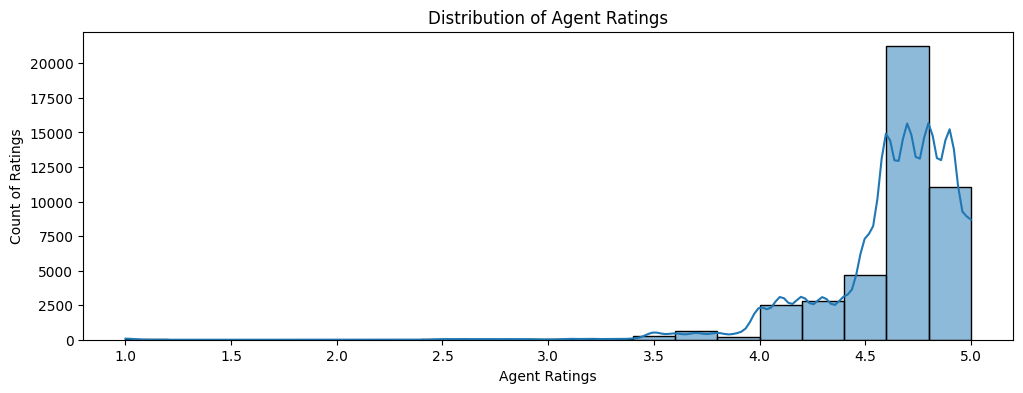

In [38]:
# 1. Distribution of Agent Ratings
plt.figure(figsize=[12,4])
sns.histplot(data = df['Agent_Rating'],kde=True,bins = 20)
plt.title('Distribution of Agent Ratings')
plt.xlabel('Agent Ratings')
plt.ylabel('Count of Ratings')
plt.show()

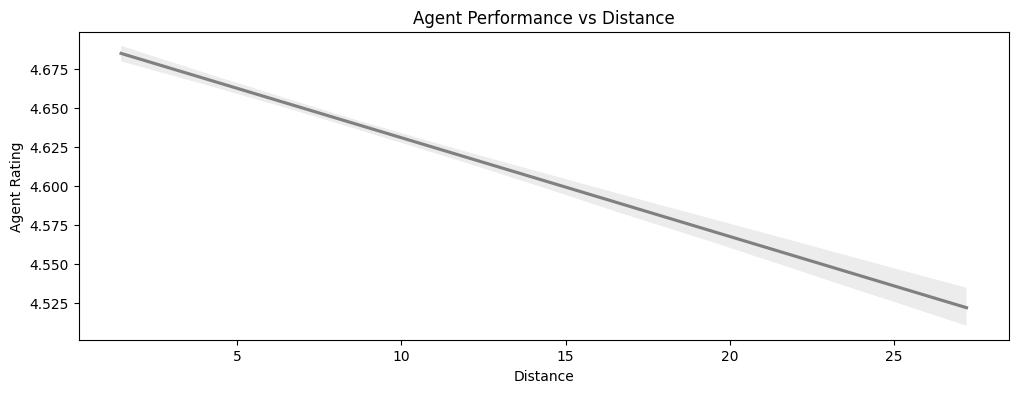

In [40]:
# 3. Agent Performance vs Distance 

plt.figure(figsize=[12,4])
sns.regplot(data=df,x=df['Distance_KM'],y=df['Agent_Rating'],scatter=False,color='grey')
plt.title('Agent Performance vs Distance')
plt.ylabel('Agent Rating')
plt.xlabel('Distance')
plt.show()

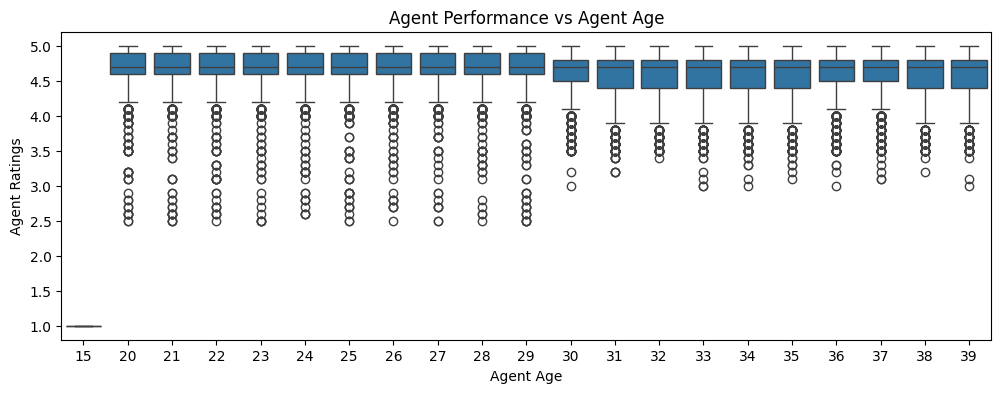

In [43]:
# Agent Performance vs Agent Age 

plt.figure(figsize=[12,4])
sns.boxplot(data=df,x=df['Agent_Age'],y=df['Agent_Rating'])
plt.title('Agent Performance vs Agent Age')
plt.xlabel('Agent Age')
plt.ylabel('Agent Ratings')
plt.show()

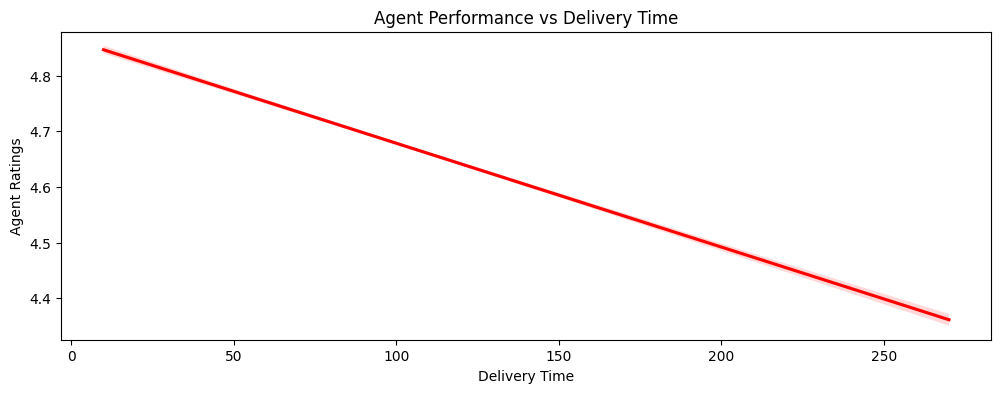

In [44]:
# Agent Performance vs Delivery time 

plt.figure(figsize=[12,4])
sns.regplot(data=df,x=df['Delivery_Time'],y=df['Agent_Rating'],scatter=False,color='red')
plt.title('Agent Performance vs Delivery Time')
plt.xlabel('Delivery Time')
plt.ylabel('Agent Ratings')
plt.show()